In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
# Read the whole dataset train.csv
whole = pd.read_csv("Data.csv")
#print(whole[0:3])
#len(whole)
#list(whole)

In [3]:
# build train dataframe with 80% of the dataset 
train_df_orig = whole.sample(frac=0.8,random_state=200) # 80%

# the remaining 20% builds test dataframe
test_df_orig = whole.drop(train_df_orig.index) # 20%

# SPLIT TRAIN ORIG into TRAIN (70%) and VALIDATION (10%)
validation_df_orig = train_df_orig.sample(frac=0.125,random_state=200) # 10%
train_df = train_df_orig.drop(validation_df_orig.index) # 70%

# So:
# train_df         70 %          3855 x 68
# validation_df    10 %          551  x 68
# test_df          20 %          1102 x 68

In [4]:
y = train_df.iloc[:,68:69].values #G3 column (not normalized)
train_df = train_df.drop(columns=['Activities_Types'])

y_validation = validation_df_orig.iloc[:,68:69].values #G3 column (not normalized)
validation_df = validation_df_orig.drop(columns=['Activities_Types'])

y_test = test_df_orig.iloc[:,68:69].values #G3 column (not normalized)
test_df = test_df_orig.drop(columns=['Activities_Types'])

In [5]:
print(y_validation[0:3])

[[3]
 [6]
 [4]]


In [6]:
np.shape(y_test)

(1102, 1)

In [7]:
np.shape(test_df)

(1102, 68)

In [8]:
y = [element[0] for element in y]

# ----- Substracting 1 to each element in y dataset in order to feed the neural network
# After the prediction, we would need to add 1 to every element of the prediction ----------
type(y)
y = [(elem - 1) for elem in y]
print(y[0:2])

# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------

y_test = [element[0] for element in y_test]

# ----- Substracting 1 to each element in y dataset in order to feed the neural network
# After the prediction, we would need to add 1 to every element of the prediction ----------
y_test = [(elem - 1) for elem in y_test]
print(y[0:2])

# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------

y_validation = [element[0] for element in y_validation]
print(y[0:20])

# ----- Substracting 1 to each element in y dataset in order to feed the neural network
# After the prediction, we would need to add 1 to every element of the prediction ----------
y_validation = [(elem - 1) for elem in y_validation]
print(y_validation[0:2])

[3, 4]
[3, 4]
[3, 4, 4, 4, 5, 1, 1, 5, 1, 0, 3, 5, 5, 5, 0, 3, 5, 1, 0, 1]
[2, 5]


In [9]:
print(y_validation[0:20])

[2, 5, 3, 1, 1, 4, 4, 4, 0, 1, 3, 0, 5, 4, 1, 1, 5, 2, 4, 3]


In [10]:
#df = pd.DataFrame(data=train_df)
len(train_df)
X = train_df.values
X_val = validation_df.values
X_test = test_df.values

In [11]:
#W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim) #68x15
#b1 = np.zeros((1, nn_hdim))
#z1 = X.dot(W1)

In [12]:
num_examples

NameError: name 'num_examples' is not defined

In [13]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model,X,y,num_examples):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [14]:
# Helper function to evaluate the total loss on the dataset each iteration
def partial_loss(W1,b1,W2,b2,probs):
    # Forward propagation to calculate our predictions
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [15]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [16]:
num_examples = len(train_df) # training set size
num_examples_val = len(validation_df) # training set size
num_examples_test = len(test_df) # training set size
nn_input_dim = 68 # input layer dimensionality
nn_output_dim = 6 # output layer dimensionality
nn_hdim = 40
 
# Gradient descent parameters (I picked these by hand)
epsilon = 0.00001 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

In [17]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=12000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim) #68x15
    b1 = np.zeros((1, nn_hdim)) #1x15
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim) #15x6
    b2 = np.zeros((1, nn_output_dim)) #1x6
    W1_val = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim) #68x15
    b1_val = np.zeros((1, nn_hdim)) #1x15
    W2_val = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim) #15x6
    b2_val = np.zeros((1, nn_output_dim)) #1x6
    #print(y2)
    #print(y.shape)
    #print(type(y))
    #print(y.shape)
    #print(np.ndindex((num_examples,6)))
    # y shape = (4406,6)
    # This is what we return at the end
    model = {}
    
    perdida = [0]*num_passes
    perdida_val = [0]*num_passes
    epochs = [0]*num_passes
    
    perdida_val = [0]*num_passes
    epochs_val = [0]*num_passes
    
    array_acc_train = [0]*num_passes
    array_acc_validation = [0]*num_passes
    
    # Gradient descent. For each batch...
    print(num_passes)
    for i in range(0, num_passes):
 
        # Forward propagation TRAINING
        z1 = X.dot(W1) + b1    #4406x68 * 68x15 = 4406x15
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) 
        
        '''# Forward propagation VALIDATION
        z1_val = X_val.dot(W1_val) + b1_val    #4406x68 * 68x15 = 4406x15
        a1_val = np.tanh(z1_val)
        z2_val = a1_val.dot(W2_val) + b2_val
        exp_scores_val = np.exp(z2_val)
        probs_val = exp_scores_val / np.sum(exp_scores_val, axis=1, keepdims=True) '''
        
        # Backpropagation TRAINING
        delta3 = probs
        #print(delta3)
        #print(delta3[range(3), [0,1,2]])
        #print(type(delta3))
        #print(np.shape(delta3))
        
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
        
        '''# Backpropagation VALIDATION
        delta3_val = probs_val        
        delta3_val[range(num_examples), y_validation] -= 1
        dW2_val = (a1_val.T).dot(delta3_val)
        db2_val = np.sum(delta3_val, axis=0, keepdims=True)
        delta2_val = delta3_val.dot(W2_val.T) * (1 - np.power(a1_val, 2))
        dW1_val = np.dot(X_val.T, delta2_val)
        db1_val = np.sum(delta2_val, axis=0)'''
 
        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
        
        '''# Add regularization terms (b1 and b2 don't have regularization terms)
        dW2_val += reg_lambda * W2_val
        dW1_val += reg_lambda * W1_val'''
 
        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2  
        
        '''# Gradient descent parameter update
        W1_val += -epsilon * dW1_val
        b1_val += -epsilon * db1_val
        W2_val += -epsilon * dW2_val
        b2_val += -epsilon * db2_val '''
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        '''# Assign new parameters to the model
        model_val = { 'W1_val': W1_val, 'b1_val': b1_val, 'W2_val': W2_val, 'b2_val': b2_val}'''
        
        perdida[i] = calculate_loss(model,X,y,num_examples)
        perdida_val[i] = calculate_loss(model,X_val,y_validation,num_examples_val)
        epochs[i] = i 
        '''perdida_val[i] = calculate_loss(model_val)
        epochs_val[i] = i '''
        
        # ------------------------- T R A I N I N G --- A c c u r a c y ----------------------------------
        # prediction wth training data
        real = predict(model, X)

        # Training Accuracy
        counter_training = 0
        total_training = len(train_df)
        # sum 1 to every prediction to make it testable
        for k in range(0, total_training):
            if real[k] == y[k]:
                counter_training += 1
        acc_train = (counter_training/total_training)
        
        array_acc_train[i] = acc_train*100
        #-----------------------------------------------------------------------------------------------
        
        # ------------------------- V A L I D A T I O N --- A c c u r a c y ----------------------------------
        # prediction wth validation data
        validation = predict(model, validation_df.values)

        # Training Accuracy
        counter_val = 0
        total_val = len(validation_df)
        # sum 1 to every prediction to make it testable
        for k in range(0, total_val):
            if validation[k] == y_validation[k]:
                counter_val += 1
        acc_val = (counter_val/total_val) # correct guesses/total guesses
        
        array_acc_validation[i] = acc_val*100
        #-----------------------------------------------------------------------------------------------
        
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            #print("TRAINING Loss after iter %i: %f" % (i, calculate_loss(model,X,y,num_examples)))
            print("VALIDATION Loss after iter %i:    %f" % (i, calculate_loss(model,X_val,y_validation,num_examples_val)))
            #print("TRAINING Accuracy after iter %i: %f" % (i, acc_train*100))
            #print("VALIDATION Accuracy for after iter %i: %f" % (i, acc_val*100))

        if i == num_passes:
            print("TRAINING Loss after iter %i: %f" % (i, calculate_loss(model,X,y,num_examples)))
            print("VALIDATION Loss after iter %i: %f" % (i, calculate_loss(model,X_val,y_validation,num_examples_val)))
            print("TRAINING Accuracy after iter %i: %f" % (i, acc_train*100))
            print("VALIDATION Accuracy for after iter %i: %f" % (i, acc_val*100))
            
           
    #plt.plot(epochs, perdida, linewidth=0.6)
    '''f1 = plt.plot(perdida, label = 'Training loss')
    f1 = plt.plot(perdida_val, label = 'Validation loss')
    f2 = plt.plot(array_acc_train, label = 'Training accuracy')
    f2 = plt.plot(array_acc_validation, label = 'Validation accuracy')
    #plt.plot(y_no_bias, label = '20.8737 Linear Regression')
    plt.legend(loc='upper left')
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)'''
    
    plt.subplot(2, 1, 1)
    plt.plot(perdida, label = 'Training loss')
    plt.plot(perdida_val, label = 'Validation loss')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.subplot(2, 1, 2)
    plt.plot(array_acc_train, label = 'Training accuracy')
    plt.plot(array_acc_validation, label = 'Validation accuracy')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()
    
    return model

12000
VALIDATION Loss after iter 0:    1.917592
VALIDATION Loss after iter 1000:    0.242435
VALIDATION Loss after iter 2000:    0.170355
VALIDATION Loss after iter 3000:    0.146340
VALIDATION Loss after iter 4000:    0.134684
VALIDATION Loss after iter 5000:    0.127349
VALIDATION Loss after iter 6000:    0.122342
VALIDATION Loss after iter 7000:    0.119355
VALIDATION Loss after iter 8000:    0.117273
VALIDATION Loss after iter 9000:    0.115609
VALIDATION Loss after iter 10000:    0.114168
VALIDATION Loss after iter 11000:    0.113276


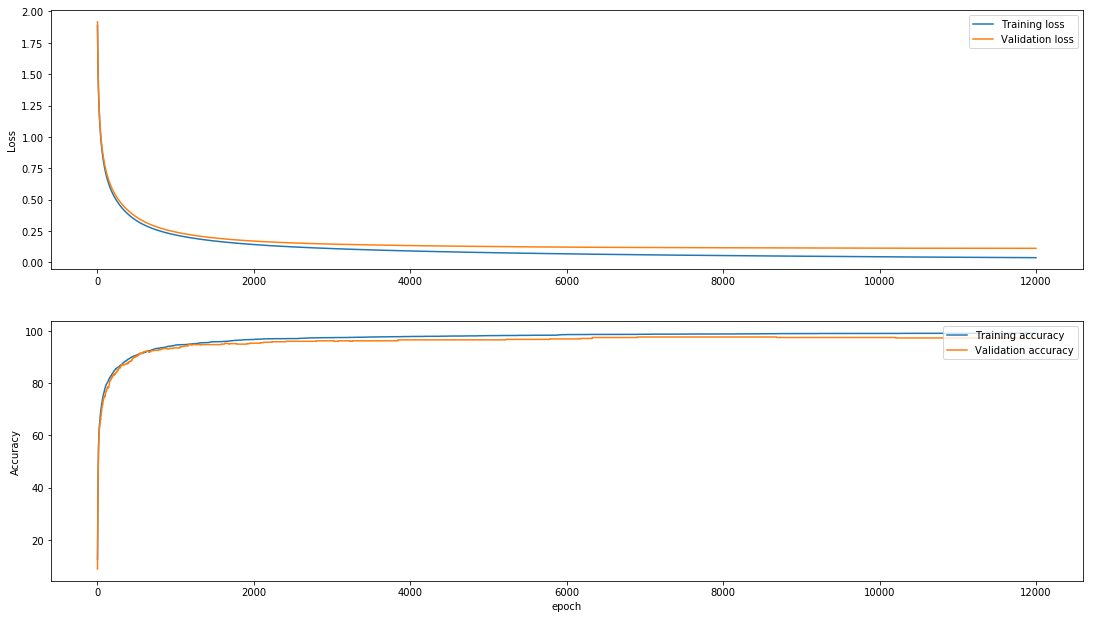

In [18]:
# Build a model with a 3-dimensional hidden layer
model = build_model(40, print_loss=True)

# Plot the decision boundary
#plot_decision_boundary(lambda x: predict(model, x))
#plt.title("Decision Boundary for hidden layer size 3")

In [19]:
# 20000 iter 40 nodes 1 hidden layer = 1.43 error
# 20000 iter 9 nodes                 = 12.8
# 20000 iter 19 nodes                = 3.57
# 20000 iter 30 nodes                = 7.9
# 50000 iter 40 nodes                = 0.92
# 50000 iter 18 nodes                = 

In [20]:
calculate_loss(model,X,y,num_examples)

0.03837690249242415

In [21]:
# It is necessary to add 1 to every element in the prediction, because we had substracted 1 for training our neural network
#prediction = prediction + 1
print(prediction[0:20])

NameError: name 'prediction' is not defined

In [22]:
# TRAINING ACCURACY

# prediction with training data
real = predict(model, X)

# Training Accuracy
counter_training = 0
total_training = len(train_df)
# sum 1 to every prediction to make it testable
for i in range(0, total_training):
    if real[i] == y[i]:
        counter_training += 1
training_acc = (counter_training/total_training)
print(counter_training/total_training)

0.9911802853437095


In [23]:
# VALIDATION ACCURACY

# prediction with validation data
validation = predict(model, validation_df.values)

# Validation Accuracy
counter_val = 0
total_val = len(validation_df)
# sum 1 to every prediction to make it testable
for i in range(0, total_val):
    if validation[i] == y_validation[i]:
        counter_val += 1
print(counter_val/total_val)

0.9709618874773139


In [24]:
# TESTING ACCURACY

# prediction with testing data
prediction = predict(model, test_df.values)

# Testing Accuracy
# test_df and y_test contain 1102 records:

counter_testing = 0
total_testing = len(test_df)
# sum 1 to every prediction to make it testable
for i in range(0, total_testing):
    if prediction[i] == y_test[i]:
        counter_testing += 1
testing_acc = (counter_testing/total_testing)
print(counter_testing/total_testing)

0.9764065335753176


In [25]:
# TRAINING LOSS
training_loss = calculate_loss(model,X,y,num_examples)
training_loss

0.03837690249242415

In [26]:
np.shape(y)

(3855,)

In [27]:
# TESTING LOSS
testing_loss = calculate_loss(model,X_test,y_test,num_examples_test)
testing_loss

0.09343777585631415

In [28]:
df_perf = {'Training': [training_acc, training_loss], 'Testing': [testing_acc, testing_loss]}
df_perf = pd.DataFrame(data = df_perf, index = ['Accuracy', 'Loss'])
df_perf

,Training,Testing
Accuracy,0.991180,0.976407
Loss,0.038377,0.093438


# Second part (ii)
## Precision, recall, F1-score (micro and macro-average)

In [29]:
# First we set each of the classes predicted (by using the testing set)

# Before we fed df_test into the NN, we manipulated the inputs, changing the range of the target y_test from [1,6] to [0,5]
# Therefore now we need to add 1 to each element for keeping the original format

# prediction is made with "model" and "test_df", and validated with "y_test"

prediction = prediction + 1

In [30]:
y_test = np.array(y_test)

In [31]:
y_test = y_test + 1

In [32]:
# Counter for true positives
counter_predict_1 = 0
counter_predict_2 = 0
counter_predict_3 = 0
counter_predict_4 = 0
counter_predict_5 = 0
counter_predict_6 = 0

# Counter for false positives
counter_fp_1 = 0
counter_fp_2 = 0
counter_fp_3 = 0
counter_fp_4 = 0
counter_fp_5 = 0
counter_fp_6 = 0

# Counter for false negatives
counter_fn_1 = 0
counter_fn_2 = 0
counter_fn_3 = 0
counter_fn_4 = 0
counter_fn_5 = 0
counter_fn_6 = 0

# Count predictions that were correct // TRUE POSITIVES
for i in range(0, len(y_test)):
    if y_test[i] == 1 and prediction[i] == 1:
        counter_predict_1 += 1
    if y_test[i] == 2 and prediction[i] == 2:
        counter_predict_2 += 1
    if y_test[i] == 3 and prediction[i] == 3:
        counter_predict_3 += 1
    if y_test[i] == 4 and prediction[i] == 4:
        counter_predict_4 += 1
    if y_test[i] == 5 and prediction[i] == 5:
        counter_predict_5 += 1
    if y_test[i] == 6 and prediction[i] == 6:
        counter_predict_6 += 1

# Count predictions that were not correct // FALSE NEGATIVE = I predict that it is not certain group but it actually IS
for i in range(0, len(y_test)):
    if y_test[i] == 1 and prediction[i] != 1:
        counter_fn_1 += 1
    if y_test[i] == 2 and prediction[i] != 2:
        counter_fn_2 += 1
    if y_test[i] == 3 and prediction[i] != 3:
        counter_fn_3 += 1
    if y_test[i] == 4 and prediction[i] != 4:
        counter_fn_4 += 1
    if y_test[i] == 5 and prediction[i] != 5:
        counter_fn_5 += 1
    if y_test[i] == 6 and prediction[i] != 6:
        counter_fn_6 += 1
        
# Count predictions that were not correct // FALSE POSITIVE = I predict it is certain group but it is NOT
for i in range(0, len(y_test)):
    if y_test[i] != 1 and prediction[i] == 1:
        counter_fp_1 += 1
    if y_test[i] != 2 and prediction[i] == 2:
        counter_fp_2 += 1
    if y_test[i] != 3 and prediction[i] == 3:
        counter_fp_3 += 1
    if y_test[i] != 4 and prediction[i] == 4:
        counter_fp_4 += 1
    if y_test[i] != 5 and prediction[i] == 5:
        counter_fp_5 += 1
    if y_test[i] != 6 and prediction[i] == 6:
        counter_fp_6 += 1

In [33]:
counter_fp_1

8

In [34]:
# P R E C I S I O N = TP / (TP + FP)

# CLASS 1
precision_1 = counter_predict_1/(counter_predict_1+counter_fp_1)
# CLASS 2
precision_2 = counter_predict_2/(counter_predict_2+counter_fp_2)
# CLASS 3
precision_3 = counter_predict_3/(counter_predict_3+counter_fp_3)
# CLASS 4
precision_4 = counter_predict_4/(counter_predict_4+counter_fp_4)
# CLASS 5
precision_5 = counter_predict_5/(counter_predict_5+counter_fp_5)
# CLASS 6
precision_6 = counter_predict_6/(counter_predict_6+counter_fp_6)

# MACRO PRECISION
tp_total = counter_predict_1+counter_predict_2+counter_predict_3+counter_predict_4+counter_predict_5+counter_predict_6
fp_total = counter_fp_1+counter_fp_2+counter_fp_3+counter_fp_4+counter_fp_5+counter_fp_6
micro_precision = tp_total/(tp_total+fp_total)
micro_precision

macro_precision = (precision_1+precision_2+precision_3+precision_4+precision_5+precision_6)/6
macro_precision

0.9674238232646794

In [35]:
# R E C A L L = TP / (TP + FN)

# CLASS 1
recall_1 = counter_predict_1/(counter_predict_1+counter_fn_1)
# CLASS 2
recall_2 = counter_predict_2/(counter_predict_2+counter_fn_2)
# CLASS 3
recall_3 = counter_predict_3/(counter_predict_3+counter_fn_3)
# CLASS 4
recall_4 = counter_predict_4/(counter_predict_4+counter_fn_4)
# CLASS 5
recall_5 = counter_predict_5/(counter_predict_5+counter_fn_5)
# CLASS 6
recall_6 = counter_predict_6/(counter_predict_6+counter_fn_6)

# MACRO PRECISION
tp_total = counter_predict_1+counter_predict_2+counter_predict_3+counter_predict_4+counter_predict_5+counter_predict_6
fn_total = counter_fn_1+counter_fn_2+counter_fn_3+counter_fn_4+counter_fn_5+counter_fn_6
micro_recall = tp_total/(tp_total+fn_total)
micro_recall

macro_recall = (recall_1+recall_2+recall_3+recall_4+recall_5+recall_6)/6
macro_recall

0.9720997242074096

In [36]:
# F - S C O R E = 2 * (Precision * Recall) / (Precision + Recall)

# CLASS 1
f_score_1 = 2*(precision_1*recall_1)/(precision_1+recall_1)
# CLASS 2
f_score_2 = 2*(precision_2*recall_2)/(precision_2+recall_2)
# CLASS 3
f_score_3 = 2*(precision_3*recall_3)/(precision_3+recall_3)
# CLASS 4
f_score_4 = 2*(precision_4*recall_4)/(precision_4+recall_4)
# CLASS 5
f_score_5 = 2*(precision_5*recall_5)/(precision_5+recall_5)
# CLASS 6
f_score_6 = 2*(precision_6*recall_6)/(precision_6+recall_6)

micro_f_score = 2*(micro_precision*micro_recall)/(micro_precision+micro_recall)
micro_f_score

macro_f_score = 2*(macro_precision*macro_recall)/(macro_precision+macro_recall)
macro_f_score

0.9697561372874295

In [37]:
df_eval = {'Precision': [precision_1, precision_2, precision_3, precision_4, precision_5, precision_5, micro_precision, macro_precision], 'Recall': [recall_1, recall_2, recall_3, recall_4, recall_5, recall_6, micro_recall, macro_recall], 'F-score': [f_score_1, f_score_2, f_score_3, f_score_4, f_score_5, f_score_6, micro_f_score, macro_f_score]}
df_eval = pd.DataFrame(data = df_eval, index = ['Class 1', 'Class 2', 'Class 3','Class 4', 'Class 5', 'Class 6', 'micro', 'macro'])
df_eval

,Precision,Recall,F-score
Class 1,0.920000,0.948454,0.934010
Class 2,0.990909,0.995434,0.993166
Class 3,0.980198,1.000000,0.990000
Class 4,0.931818,0.924812,0.928302
Class 5,0.981618,0.963899,0.972678
Class 6,0.981618,1.000000,1.000000
micro,0.976407,0.976407,0.976407
macro,0.967424,0.972100,0.969756


# (iv) PCA and 2 principal components

In [38]:
# Our validation dataset contains = features + target (Activities_Types)
#validation_df_orig = validation_df_orig.astype({"Activities_Types": str})
#validation_df_orig['Activities_Types'] = validation_df_orig['Activities_Types'].map({'1': 'downstairs', '2': 'upstairs', '3': 'sitting', '4': 'standing', '5': 'walking', '6': 'jogging'})
validation_df_orig[0:2]

,attitude_max_roll,attitude_max_pitch,attitude_max_yaw,gravity_max_x,gravity_max_y,gravity_max_z,rotationRate_max_x,rotationRate_max_y,rotationRate_max_z,userAcceleration_max_x,...,attitude_skew_roll,attitude_skew_yaw,gravity_skew_x,gravity_skew_y,gravity_skew_z,rotationRate_skew_x,rotationRate_skew_y,rotationRate_skew_z,userAcceleration_skew_x,Activities_Types
2080,-0.168139,-0.330985,2.548639,-0.133801,0.903700,-0.271377,5.141771,5.637589,3.722824,1.574891,...,-0.650091,-0.237709,-0.045487,-0.537471,0.289306,-0.580209,-0.785863,-0.794836,-0.944554,3
2336,-0.204823,0.027015,-0.167012,-0.203320,-0.016717,-0.977521,0.021440,0.027254,0.016386,0.025117,...,0.061136,0.812512,0.080939,-0.808717,0.411306,-1.335608,-0.623323,0.504980,0.400425,6


In [39]:
type(validation_df_orig)

pandas.core.frame.DataFrame

In [40]:
# Now we need to scale our data (all features except target), before applying PCA

from sklearn.preprocessing import StandardScaler
features = ['attitude_max_roll',
 'attitude_max_pitch',
 'attitude_max_yaw',
 'gravity_max_x',
 'gravity_max_y',
 'gravity_max_z',
 'rotationRate_max_x',
 'rotationRate_max_y',
 'rotationRate_max_z',
 'userAcceleration_max_x',
 'userAcceleration_max_y',
 'userAcceleration_max_z',
 'attitude_sum_roll',
 'attitude_sum_pitch',
 'attitude_sum_yaw',
 'gravity_sum_x',
 'gravity_sum_y',
 'gravity_sum_z',
 'rotationRate_sum_x',
 'rotationRate_sum_y',
 'rotationRate_sum_z',
 'userAcceleration_sum_x',
 'userAcceleration_sum_y',
 'attitude_min_roll',
 'attitude_min_pitch',
 'attitude_min_yaw',
 'gravity_min_x',
 'gravity_min_y',
 'gravity_min_z',
 'rotationRate_min_x',
 'rotationRate_min_y',
 'rotationRate_min_z',
 'userAcceleration_min_x',
 'userAcceleration_min_y',
 'userAcceleration_min_z',
 'attitude_sumSS_roll',
 'attitude_sumSS_pitch',
 'attitude_sumSS_yaw',
 'gravity_sumSS_x',
 'gravity_sumSS_y',
 'gravity_sumSS_z',
 'rotationRate_sumSS_x',
 'rotationRate_sumSS_y',
 'rotationRate_sumSS_z',
 'userAcceleration_sumSS_x',
 'userAcceleration_sumSS_y',
 'userAcceleration_sumSS_z',
 'attitude_std_roll',
 'attitude_std_pitch',
 'attitude_std_yaw',
 'gravity_std_x',
 'gravity_std_y',
 'gravity_std_z',
 'rotationRate_std_x',
 'rotationRate_std_y',
 'rotationRate_std_z',
 'userAcceleration_std_x',
 'userAcceleration_std_y',
 'attitude_skew_pitch',
 'attitude_skew_roll',
 'attitude_skew_yaw',
 'gravity_skew_x',
 'gravity_skew_y',
 'gravity_skew_z',
 'rotationRate_skew_x',
 'rotationRate_skew_y',
 'rotationRate_skew_z',
 'userAcceleration_skew_x']
# Separating out the features
x = validation_df_orig.loc[:, features].values
# Separating out the target Activities_Types
y = validation_df_orig.loc[:,['Activities_Types']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [41]:
print(principalComponents)

NameError: name 'principalComponents' is not defined

In [42]:
print(y[0:3])

[[3]
 [6]
 [4]]


In [43]:
print(principalComponents_y)

NameError: name 'principalComponents_y' is not defined

In [44]:
print(validation_df_orig[['Activities_Types']][0:3])

      Activities_Types
2080                 3
2336                 6
2002                 4


In [45]:
# Now the PCA has to project all the features (68 features) into only 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalComponents_y = np.concatenate((principalComponents, y), axis=1)
principalDf = pd.DataFrame(data = principalComponents_y
             , columns = ['principal component 1', 'principal component 2','Activities_Types'])
finalDf = principalDf

In [46]:
#finalDf = pd.concat([principalDf, validation_df_orig['Activities_Types']], axis = 1)
#finalDf = pd.concat([principalDf, y], axis = 1)

In [47]:
print(principalDf[0:3])

   principal component 1  principal component 2  Activities_Types
0              10.081197               6.424303               3.0
1              -6.513867               5.896376               6.0
2               3.391873              -1.161315               4.0


In [48]:
len(finalDf)

551

In [49]:
principalDf[['Activities_Types']][0:3]

,Activities_Types
0,3.0
1,6.0
2,4.0


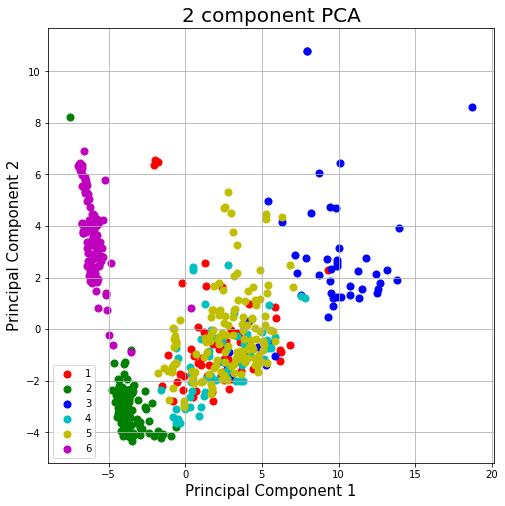

In [50]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
#targets = ['downstairs', 'upstairs', 'sitting', 'standing', 'walking', 'jogging']
targets = [1,2,3,4,5,6]
colors = ['r', 'g', 'b', 'c', 'y', 'm']
for target, color in zip(targets,colors):
#for target in targets:
    indicesToKeep = finalDf['Activities_Types'] == target
    #indicesToKeep = finalDf[3] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

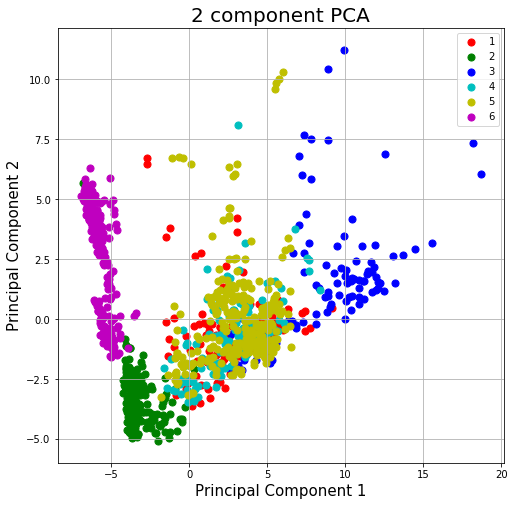

In [51]:
# TEST DATASET

# Our test dataset contains = features + target (Activities_Types)
#test_df_orig = test_df_orig.astype({"Activities_Types": str})
#test_df_orig['Activities_Types'] = test_df_orig['Activities_Types'].map({'1': 'downstairs', '2': 'upstairs', '3': 'sitting', '4': 'standing', '5': 'walking', '6': 'jogging'})
test_df_orig[0:2]

# Now we need to scale our data (all features except target), before applying PCA

from sklearn.preprocessing import StandardScaler
features = ['attitude_max_roll',
 'attitude_max_pitch',
 'attitude_max_yaw',
 'gravity_max_x',
 'gravity_max_y',
 'gravity_max_z',
 'rotationRate_max_x',
 'rotationRate_max_y',
 'rotationRate_max_z',
 'userAcceleration_max_x',
 'userAcceleration_max_y',
 'userAcceleration_max_z',
 'attitude_sum_roll',
 'attitude_sum_pitch',
 'attitude_sum_yaw',
 'gravity_sum_x',
 'gravity_sum_y',
 'gravity_sum_z',
 'rotationRate_sum_x',
 'rotationRate_sum_y',
 'rotationRate_sum_z',
 'userAcceleration_sum_x',
 'userAcceleration_sum_y',
 'attitude_min_roll',
 'attitude_min_pitch',
 'attitude_min_yaw',
 'gravity_min_x',
 'gravity_min_y',
 'gravity_min_z',
 'rotationRate_min_x',
 'rotationRate_min_y',
 'rotationRate_min_z',
 'userAcceleration_min_x',
 'userAcceleration_min_y',
 'userAcceleration_min_z',
 'attitude_sumSS_roll',
 'attitude_sumSS_pitch',
 'attitude_sumSS_yaw',
 'gravity_sumSS_x',
 'gravity_sumSS_y',
 'gravity_sumSS_z',
 'rotationRate_sumSS_x',
 'rotationRate_sumSS_y',
 'rotationRate_sumSS_z',
 'userAcceleration_sumSS_x',
 'userAcceleration_sumSS_y',
 'userAcceleration_sumSS_z',
 'attitude_std_roll',
 'attitude_std_pitch',
 'attitude_std_yaw',
 'gravity_std_x',
 'gravity_std_y',
 'gravity_std_z',
 'rotationRate_std_x',
 'rotationRate_std_y',
 'rotationRate_std_z',
 'userAcceleration_std_x',
 'userAcceleration_std_y',
 'attitude_skew_pitch',
 'attitude_skew_roll',
 'attitude_skew_yaw',
 'gravity_skew_x',
 'gravity_skew_y',
 'gravity_skew_z',
 'rotationRate_skew_x',
 'rotationRate_skew_y',
 'rotationRate_skew_z',
 'userAcceleration_skew_x']
# Separating out the features
x = test_df_orig.loc[:, features].values
# Separating out the target Activities_Types
y = test_df_orig.loc[:,['Activities_Types']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

# Now the PCA has to project all the features (68 features) into only 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalComponents_y = np.concatenate((principalComponents, y), axis=1)
principalDf = pd.DataFrame(data = principalComponents_y
             , columns = ['principal component 1', 'principal component 2','Activities_Types'])

finalDf = principalDf

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
#targets = ['downstairs', 'upstairs', 'sitting', 'standing', 'walking', 'jogging']
targets = [1,2,3,4,5,6]
colors = ['r', 'g', 'b', 'c', 'y', 'm']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Activities_Types'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# (v) t-SNE

In [52]:
import time
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1102 samples in 0.003s...
[t-SNE] Computed neighbors for 1102 samples in 0.177s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1102
[t-SNE] Computed conditional probabilities for sample 1102 / 1102
[t-SNE] Mean sigma: 2.573920
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.227898
[t-SNE] KL divergence after 300 iterations: 0.834010
t-SNE done! Time elapsed: 3.167371988296509 seconds


In [53]:
print(principalDf[0:3])

   principal component 1  principal component 2  Activities_Types
0              -6.366112               4.141485               6.0
1              -6.480422               4.406320               6.0
2               4.538591              -1.334584               3.0


In [54]:
print(principalDf[0:3])

   principal component 1  principal component 2  Activities_Types
0              -6.366112               4.141485               6.0
1              -6.480422               4.406320               6.0
2               4.538591              -1.334584               3.0


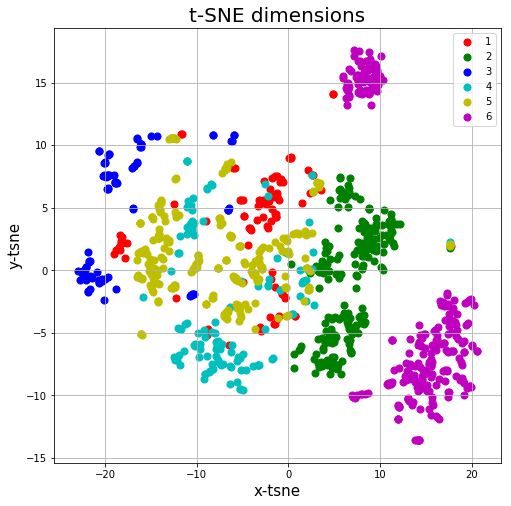

In [55]:
tsne_results_y = np.concatenate((tsne_results, y), axis=1)
principalDf = pd.DataFrame(data = tsne_results_y
             , columns = ['x-tsne', 'y-tsne','Activities_Types'])
finalDf = principalDf
#finalDf = pd.concat([principalDf, test_df_orig['Activities_Types']], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('x-tsne', fontsize = 15)
ax.set_ylabel('y-tsne', fontsize = 15)
ax.set_title('t-SNE dimensions', fontsize = 20)
#targets = ['downstairs', 'upstairs', 'sitting', 'standing', 'walking', 'jogging']
targets = [1,2,3,4,5,6]
colors = ['r', 'g', 'b', 'c', 'y', 'm']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Activities_Types'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'x-tsne']
               , finalDf.loc[indicesToKeep, 'y-tsne']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Hidden Test Set

In [56]:
# Read the whole dataset test_no_Ac.csv
whole_test = pd.read_csv("test_no_Ac.csv")
print(whole_test[0:3])
len(whole_test)

   attitude_max_roll  attitude_max_pitch  attitude_max_yaw  gravity_max_x  \
0          -0.831907           -0.637383          3.093231      -0.586844   
1           0.002482           -0.743562         -0.641182       0.001545   
2          -2.653296           -0.077918         -0.411637      -0.455793   

   gravity_max_y  gravity_max_z  rotationRate_max_x  rotationRate_max_y  \
0       0.807047       0.147621            3.856673            2.386889   
1       0.994576       0.072182            4.313818            7.107692   
2       0.093805       0.885836            0.032580            0.057317   

   rotationRate_max_z  userAcceleration_max_x           ...             \
0            1.460328                0.693459           ...              
1            1.795167                0.632683           ...              
2            0.040802                0.039537           ...              

   attitude_skew_pitch  attitude_skew_roll  attitude_skew_yaw  gravity_skew_x  \
0           

1378

In [57]:
if list(train_df) == list(whole_test):
    print("igual")

igual


In [58]:
type(whole_test.values)

numpy.ndarray

In [59]:
type(x)

numpy.ndarray

In [60]:
hidden_test = predict(model,whole_test.values)

In [61]:
hidden_test += 1

In [62]:
len(hidden_test)

1378

In [63]:
print(hidden_test[0:20])

[1 5 6 3 4 5 5 1 5 5 2 2 6 1 3 2 6 2 6 1]


In [64]:
index = np.arange(1378)
type(index)
len(index)
print(index)

[   0    1    2 ... 1375 1376 1377]


In [65]:
hidden_test_index = np.concatenate((hidden_test, index), axis=0)

In [66]:
print(hidden_test_index)

[   1    5    6 ... 1375 1376 1377]


In [67]:
np.savetxt('107065431_Ac1.txt', hidden_test, fmt='%d')